# Fraudulent Transactions Prediction


## Defining the problem statement

You need to deliver to the  Company a production model in which your access will be done via API, that is, Any transaction in the account that was not authorised directly by the card / account holder is 
considered to be a fraudulent transaction.So Customers will send their transactions via API so that your model classifies them as fraudulent or legitimate.

# <font color = 'red'> Imports and Helper Functions

## <font color = 'blue'> Imports

In [1]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import plotly.express as px

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML 

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## <font color = 'blue'> Helper Functions

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    sns.set(font_scale=1.6)
    
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy =", accuracy_score(y_actual, y_predicted))
    print("Precision =", precision_score(y_actual, y_predicted))
    print("Recall = ", recall_score(y_actual, y_predicted))
    print("F1 Score =" ,f1_score(y_actual, y_predicted))
    pass

In [5]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [6]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [7]:
def generate_auc_roc_curve (classifier, X_test):
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr, tpr, label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

# <font color = 'red'> Data Description

## <font color = 'blue'> Loading Data

In [8]:
df=pd.read_csv("Fraud.csv")
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0

In [9]:
df.tail()

step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
6362615   743  CASH_OUT   339682.13   C786484425      339682.13             0.0   C776919290            0.00       339682.13        1               0
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28             0.0  C1881841831            0.00            0.00        1               0
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28             0.0  C1365125890        68488.84      6379898.11        1               0
6362618   743  TRANSFER   850002.52  C1685995037      850002.52             0.0  C2080388513            0.00            0.00        1               0
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52             0.0   C873221189      6510099.11      7360101.63        1               0

## <font color = 'blue'> Columns

### <font color = 'blue'> Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## <font color = 'blue'> Data Dimension 

In [10]:
print('Number of Rows: {}'.format(df.shape[0]))
print('Number of Cols: {}'.format(df.shape[1]))

Number of Rows: 6362620
Number of Cols: 11


In [11]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## <font color = 'blue'>Data Types and Structure

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## <font color = 'blue'> Check NA

In [13]:
df.isna().mean()

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

In [14]:
#check the fraud transaction 
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

## <font color = 'blue'> Fill Out NA

There's no NaN values to fill.

### <font color = 'red'>Applying new conditions and columns

In [15]:
df['dest_increase'] = (df['newbalanceDest']- df['oldbalanceDest']).values
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0            0.0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0            0.0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0            0.0
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0       -21182.0
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0            0.0

### <font color = 'blue'>we compute the change in balances of origin accounts to use later 

In [16]:

df['origin_bal_change'] = (df['oldbalanceOrg'] - df['newbalanceOrig']).values
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase  origin_bal_change
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0            0.0            9839.64
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0            0.0            1864.28
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0            0.0             181.00
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0       -21182.0             181.00
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0            0.0           11668.14

In [17]:
mask = (df['dest_increase']==0.0) & (df['amount']>0)
df['possible_fraud'] = 0
df.loc[mask,'possible_fraud'] = 1
df[df['possible_fraud']==1].head(10)

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase  origin_bal_change  possible_fraud
0      1   PAYMENT   9839.64  C1231006815      170136.00       160296.36  M1979787155             0.0             0.0        0               0            0.0            9839.64               1
1      1   PAYMENT   1864.28  C1666544295       21249.00        19384.72  M2044282225             0.0             0.0        0               0            0.0            1864.28               1
2      1  TRANSFER    181.00  C1305486145         181.00            0.00   C553264065             0.0             0.0        1               0            0.0             181.00               1
4      1   PAYMENT  11668.14  C2048537720       41554.00        29885.86  M1230701703             0.0             0.0        0               0            0.0           11668.14               1
5      1   PAYMENT   7817.71    C90045638       53860.00        46042.29   M573487274             0.0             0.0        0               0            0.0            7817.71               1
6      1   PAYMENT   7107.77   C154988899      183195.00       176087.23   M408069119             0.0             0.0        0               0            0.0            7107.77               1
7      1   PAYMENT   7861.64  C1912850431      176087.23       168225.59   M633326333             0.0             0.0        0               0            0.0            7861.64               1
8      1   PAYMENT   4024.36  C1265012928        2671.00            0.00  M1176932104             0.0             0.0        0               0            0.0            2671.00               1
11     1   PAYMENT   3099.97   C249177573       20771.00        17671.03  M2096539129             0.0             0.0        0               0            0.0            3099.97               1
12     1   PAYMENT   2560.74  C1648232591        5070.00         2509.26   M972865270             0.0             0.0        0               0            0.0            2560.74               1

In [18]:
mask2 = ((df['dest_increase']!=df['amount']) & (df['possible_fraud']==0))
df['possible_fraud2'] = 0
df.loc[mask2,'possible_fraud2'] = 1
df[df['possible_fraud2']==1].head(10)

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase  origin_bal_change  possible_fraud  possible_fraud2
3      1  CASH_OUT     181.00   C840083671         181.00            0.00    C38997010         21182.0            0.00        1               0      -21182.00             181.00               0                1
9      1     DEBIT    5337.77   C712410124       41720.00        36382.23   C195600860         41898.0        40348.79        0               0       -1549.21            5337.77               0                1
10     1     DEBIT    9644.94  C1900366749        4465.00            0.00   C997608398         10845.0       157982.12        0               0      147137.12            4465.00               0                1
15     1  CASH_OUT  229133.94   C905080434       15325.00            0.00   C476402209          5083.0        51513.44        0               0       46430.44           15325.00               0                1
19     1  TRANSFER  215310.30  C1670993182         705.00            0.00  C1100439041         22425.0            0.00        0               0      -22425.00             705.00               0                1
21     1     DEBIT    9302.79  C1566511282       11299.00         1996.21  C1973538135         29832.0        16896.70        0               0      -12935.30            9302.79               0                1
22     1     DEBIT    1065.41  C1959239586        1817.00          751.59   C515132998         10330.0            0.00        0               0      -10330.00            1065.41               0                1
24     1  TRANSFER  311685.89  C1984094095       10835.00            0.00   C932583850          6267.0      2719172.89        0               0     2712905.89           10835.00               0                1
41     1     DEBIT    5758.59  C1466917878       32604.00        26845.41  C1297685781        209699.0        16997.22        0               0     -192701.78            5758.59               0                1
42     1  CASH_OUT  110414.71   C768216420       26845.41            0.00  C1509514333        288800.0         2415.16        0               0     -286384.84           26845.41               0                1

In [19]:
df['possible_fraud3']=((df['possible_fraud']==1)|(df['possible_fraud2']==1))

In [20]:
df[df['possible_fraud3']==0].head(10)

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase  origin_bal_change  possible_fraud  possible_fraud2  possible_fraud3
811      1  TRANSFER   84212.94  C1336775847       53199.00            0.00    C13329486            0.00        84212.94        0               0       84212.94           53199.00               0                0            False
1169     1  CASH_OUT    9980.32  C1589466857       12936.00         2955.68  C1018298342            0.00         9980.32        0               0        9980.32            9980.32               0                0            False
1204     1  TRANSFER   19772.53   C792488644           0.00            0.00  C2094777811        44486.99        64259.52        0               0       19772.53               0.00               0                0            False
1428     1  TRANSFER  139555.44  C1733619456       19466.00            0.00   C317071334            0.00       139555.44        0               0      139555.44           19466.00               0                0            False
1870     1  CASH_OUT   25071.46  C1275464847       25071.46            0.00  C1364913072         9083.76        34155.22        1               0       25071.46           25071.46               0                0            False
1911     1  CASH_OUT  132842.64    C13692003        4499.08            0.00   C297927961            0.00       132842.64        1               0      132842.64            4499.08               0                0            False
1978     1     DEBIT    4479.63  C1418851979      154215.60       149735.97   C339924917         7666.22        12145.85        0               0        4479.63            4479.63               0                0            False
2110     1     DEBIT     454.51   C199150625       30818.00        30363.49    C13226198          916.00         1370.51        0               0         454.51             454.51               0                0            False
2125     1  TRANSFER   22190.99  C2017380745       52231.01        30040.03  C1170794006            0.00        22190.99        0               0       22190.99           22190.98               0                0            False
2220     1  CASH_OUT  219630.79   C602830277       19779.08            0.00  C2118255842        29186.69       248817.48        0               0      219630.79           19779.08               0                0            False

In [21]:
df[df['possible_fraud3']==1].head(10)

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase  origin_bal_change  possible_fraud  possible_fraud2  possible_fraud3
0     1   PAYMENT   9839.64  C1231006815      170136.00       160296.36  M1979787155             0.0            0.00        0               0           0.00            9839.64               1                0             True
1     1   PAYMENT   1864.28  C1666544295       21249.00        19384.72  M2044282225             0.0            0.00        0               0           0.00            1864.28               1                0             True
2     1  TRANSFER    181.00  C1305486145         181.00            0.00   C553264065             0.0            0.00        1               0           0.00             181.00               1                0             True
3     1  CASH_OUT    181.00   C840083671         181.00            0.00    C38997010         21182.0            0.00        1               0      -21182.00             181.00               0                1             True
4     1   PAYMENT  11668.14  C2048537720       41554.00        29885.86  M1230701703             0.0            0.00        0               0           0.00           11668.14               1                0             True
5     1   PAYMENT   7817.71    C90045638       53860.00        46042.29   M573487274             0.0            0.00        0               0           0.00            7817.71               1                0             True
6     1   PAYMENT   7107.77   C154988899      183195.00       176087.23   M408069119             0.0            0.00        0               0           0.00            7107.77               1                0             True
7     1   PAYMENT   7861.64  C1912850431      176087.23       168225.59   M633326333             0.0            0.00        0               0           0.00            7861.64               1                0             True
8     1   PAYMENT   4024.36  C1265012928        2671.00            0.00  M1176932104             0.0            0.00        0               0           0.00            2671.00               1                0             True
9     1     DEBIT   5337.77   C712410124       41720.00        36382.23   C195600860         41898.0        40348.79        0               0       -1549.21            5337.77               0                1             True

In [22]:
df.possible_fraud3.value_counts()

True     5602260
False     760360
Name: possible_fraud3, dtype: int64

In [23]:
df1=df.copy()
df1['possible_fraud3'] = df1['possible_fraud3'].astype(int)

## <font color = 'blue'> Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [24]:
df1['possible_fraud3'] = df1['possible_fraud3'].map({1: 'yes', 0: 'no'})   

In [25]:
df1.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  dest_increase  origin_bal_change  possible_fraud  possible_fraud2 possible_fraud3
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0            0.0            9839.64               1                0             yes
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0            0.0            1864.28               1                0             yes
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0            0.0             181.00               1                0             yes
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0       -21182.0             181.00               0                1             yes
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0            0.0           11668.14               1                0             yes

In [26]:
data=df1.drop(['nameOrig','nameDest','isFraud','isFlaggedFraud',"possible_fraud","possible_fraud2"],axis=1)
data.head(10)

step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  dest_increase  origin_bal_change possible_fraud3
0     1   PAYMENT   9839.64      170136.00       160296.36             0.0            0.00           0.00            9839.64             yes
1     1   PAYMENT   1864.28       21249.00        19384.72             0.0            0.00           0.00            1864.28             yes
2     1  TRANSFER    181.00         181.00            0.00             0.0            0.00           0.00             181.00             yes
3     1  CASH_OUT    181.00         181.00            0.00         21182.0            0.00      -21182.00             181.00             yes
4     1   PAYMENT  11668.14       41554.00        29885.86             0.0            0.00           0.00           11668.14             yes
5     1   PAYMENT   7817.71       53860.00        46042.29             0.0            0.00           0.00            7817.71             yes
6     1   PAYMENT   7107.77      183195.00       176087.23             0.0            0.00           0.00            7107.77             yes
7     1   PAYMENT   7861.64      176087.23       168225.59             0.0            0.00           0.00            7861.64             yes
8     1   PAYMENT   4024.36        2671.00            0.00             0.0            0.00           0.00            2671.00             yes
9     1     DEBIT   5337.77       41720.00        36382.23         41898.0        40348.79       -1549.21            5337.77             yes

In [27]:
data.isna().mean()

step                 0.0
type                 0.0
amount               0.0
oldbalanceOrg        0.0
newbalanceOrig       0.0
oldbalanceDest       0.0
newbalanceDest       0.0
dest_increase        0.0
origin_bal_change    0.0
possible_fraud3      0.0
dtype: float64

### <font color = 'red'> Description Statistics

In [28]:
num_attributes = data.select_dtypes(exclude='object')
cat_attributes = data.select_dtypes(include='object')

### <font color = 'blue'> Numerical Attributes

In [29]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

count          mean           std          min       25%         50%           75%           max         range  variation coefficient       skew     kurtosis
step               6362620.0  2.433972e+02  1.423320e+02         1.00    156.00     239.000  3.350000e+02  7.430000e+02  7.420000e+02               0.584772   0.375177     0.329071
amount             6362620.0  1.798619e+05  6.038582e+05         0.00  13389.57   74871.940  2.087215e+05  9.244552e+07  9.244552e+07               3.357344  30.993949  1797.956705
oldbalanceOrg      6362620.0  8.338831e+05  2.888243e+06         0.00      0.00   14208.000  1.073152e+05  5.958504e+07  5.958504e+07               3.463606   5.249136    32.964879
newbalanceOrig     6362620.0  8.551137e+05  2.924049e+06         0.00      0.00       0.000  1.442584e+05  4.958504e+07  4.958504e+07               3.419485   5.176884    32.066985
oldbalanceDest     6362620.0  1.100702e+06  3.399180e+06         0.00      0.00  132705.665  9.430367e+05  3.560159e+08  3.560159e+08               3.088194  19.921758   948.674125
newbalanceDest     6362620.0  1.224996e+06  3.674129e+06         0.00      0.00  214661.440  1.111909e+06  3.561793e+08  3.561793e+08               2.999298  19.352302   862.156508
dest_increase      6362620.0  1.242947e+05  8.129391e+05 -13060826.21      0.00       0.000  1.491054e+05  1.056878e+08  1.187487e+08               6.540415  32.916341  1765.310944
origin_bal_change  6362620.0 -2.123056e+04  1.466433e+05  -1915267.90      0.00       0.000  1.015044e+04  1.000000e+07  1.191527e+07              -6.907178  24.630520  1509.981332

* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables are higher shap and right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### <font color = 'blue'> Categorical Attributes

In [30]:
cat_attributes.describe()

type possible_fraud3
count    6362620         6362620
unique         5               2
top     CASH_OUT             yes
freq     2237500         5602260

* The majority type is cash_out with 2237500.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# <font color = 'red'> Feature Engineering

## <font color = 'blue'> Mind Map

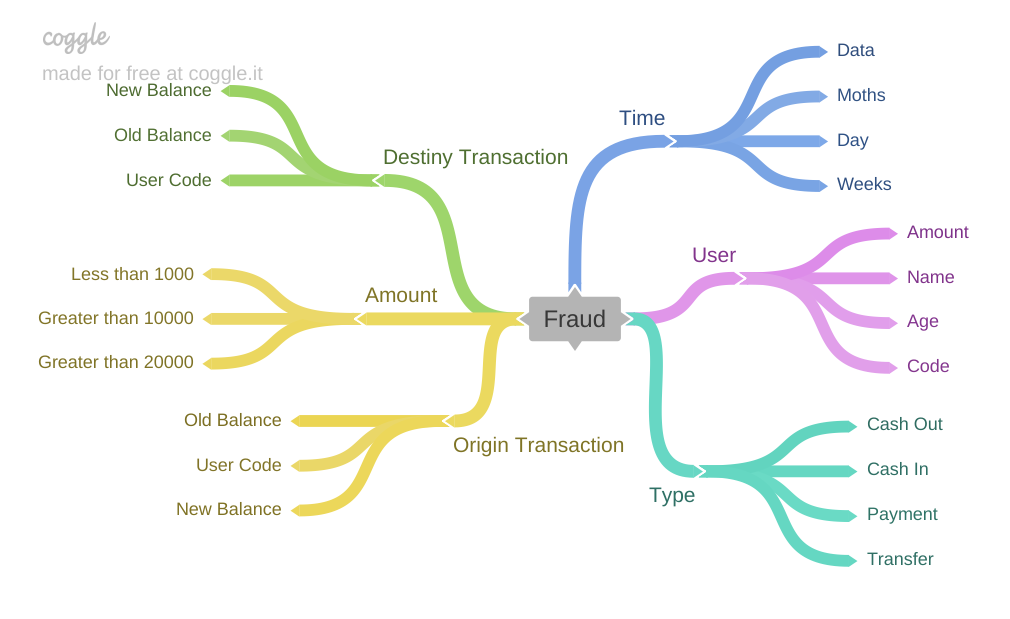

### <font color = 'blue'> Feature Engineering

In [28]:
# step
data['step_days'] = data['step'].apply(lambda i: i/24)  
data['step_weeks'] = data['step'].apply(lambda i: i/(24*7))


In [29]:
data.head()

step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  dest_increase  origin_bal_change possible_fraud3  step_days  step_weeks
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0             0.0            0.0            9839.64             yes   0.041667    0.005952
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0             0.0            0.0            1864.28             yes   0.041667    0.005952
2     1  TRANSFER    181.00          181.0            0.00             0.0             0.0            0.0             181.00             yes   0.041667    0.005952
3     1  CASH_OUT    181.00          181.0            0.00         21182.0             0.0       -21182.0             181.00             yes   0.041667    0.005952
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0             0.0            0.0           11668.14             yes   0.041667    0.005952

# <font color = 'red'> Exploratory Data Analisys

## <font color = 'blue'>Univariate Analysis

###  Response Variable

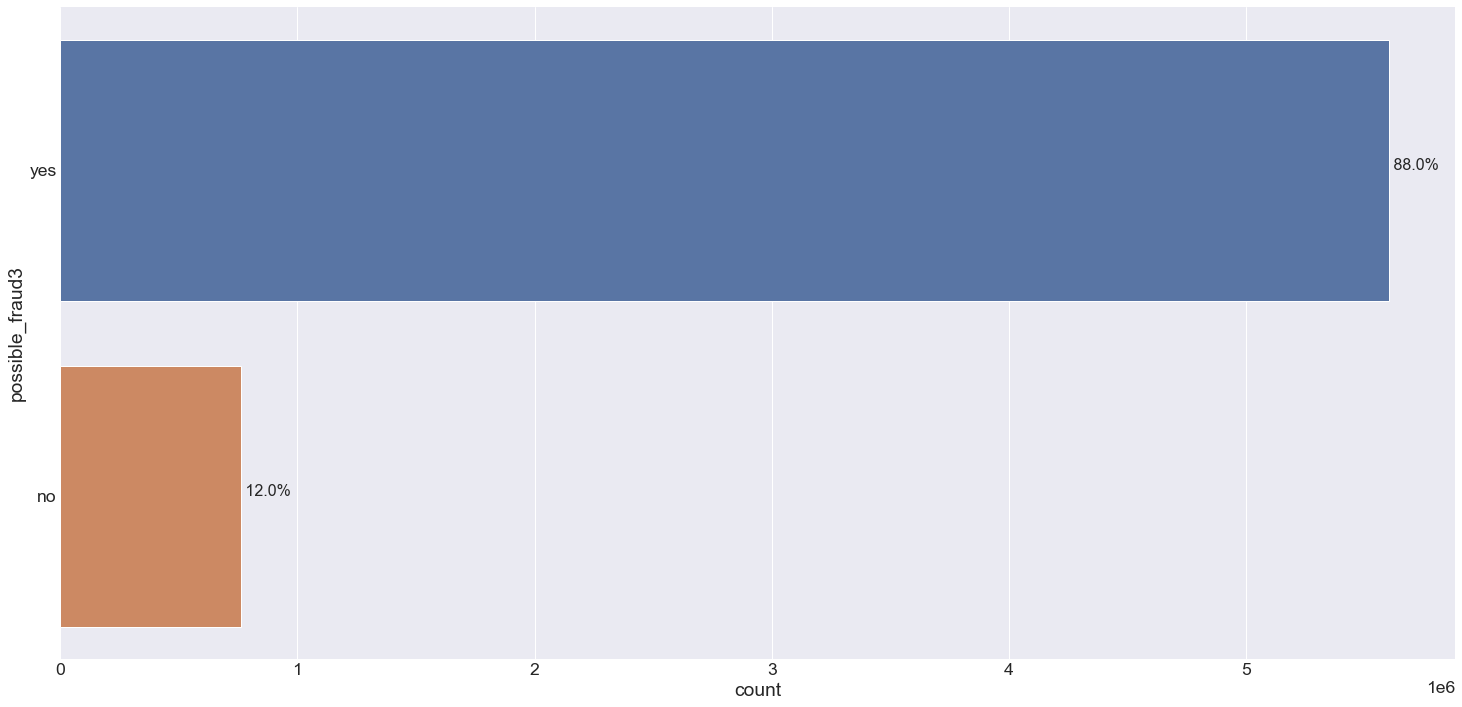

In [33]:
ax = sns.countplot(y='possible_fraud3', data=data);

total = data['possible_fraud3'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))


### Numerical Variables

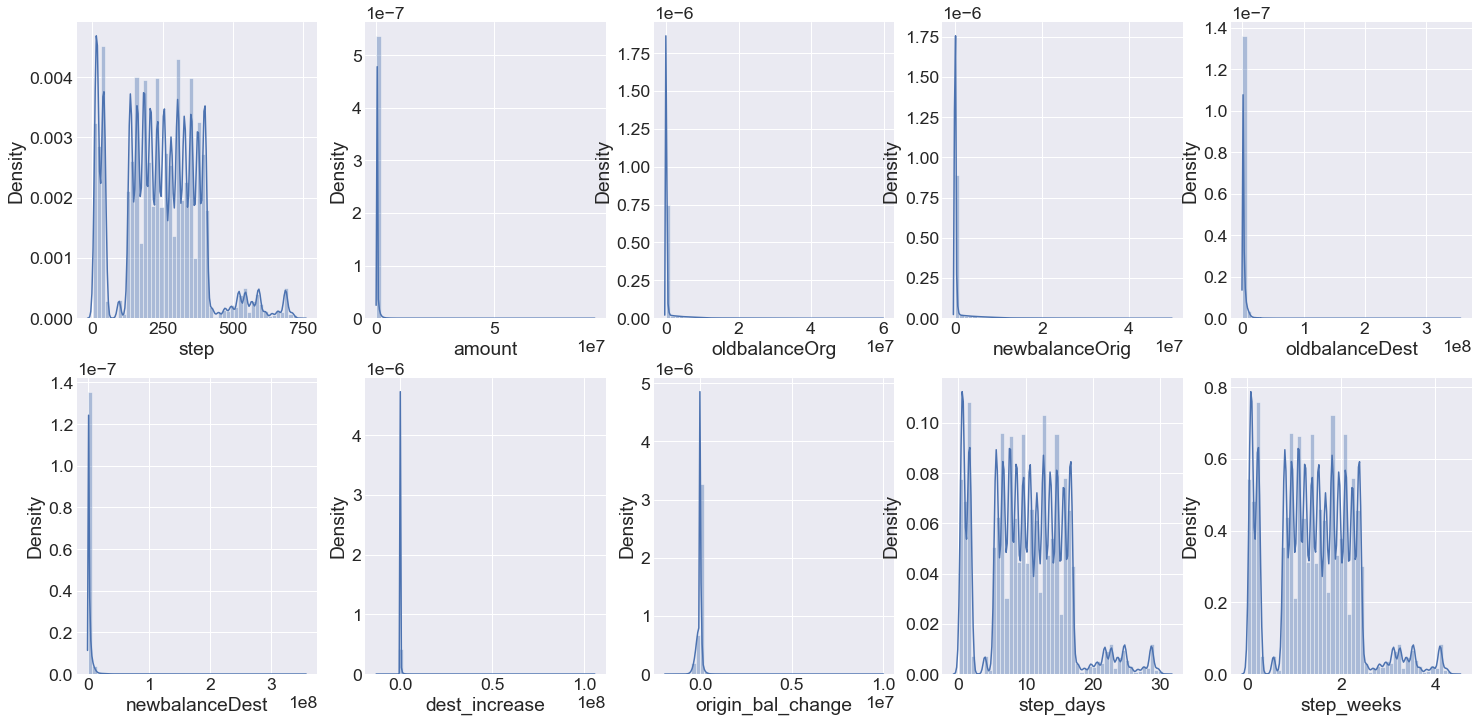

In [34]:
num_attributes = data.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);
    
    j += 1

###  Categorical Variables

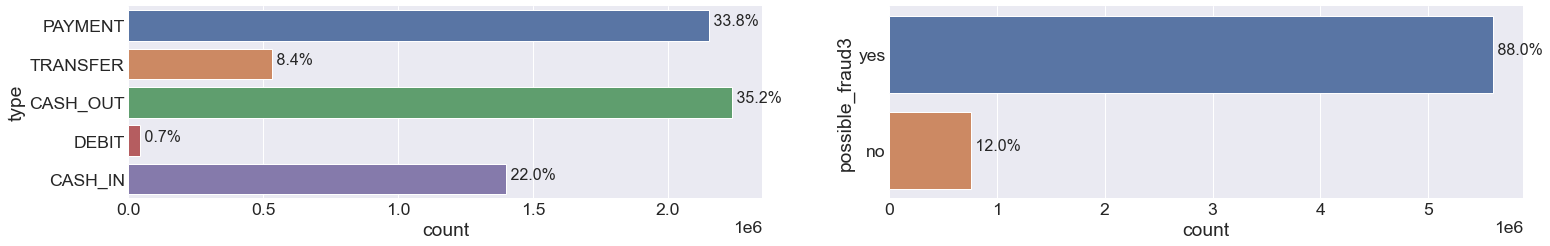

In [35]:
cat_attributes = data.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

### Distribution of Transaction Types

In [36]:
type = data["type"].value_counts()
transactions = type.index
quantity = type.values

plot = px.pie(data, values=quantity, names = transactions, hole = 0.5, title = "Distribution of Transaction Types")
plot.show()

## <font color = 'blue'> Bivariate Analysis

###  All the fraud amount is greater than 10.000.

**TRUE:** The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

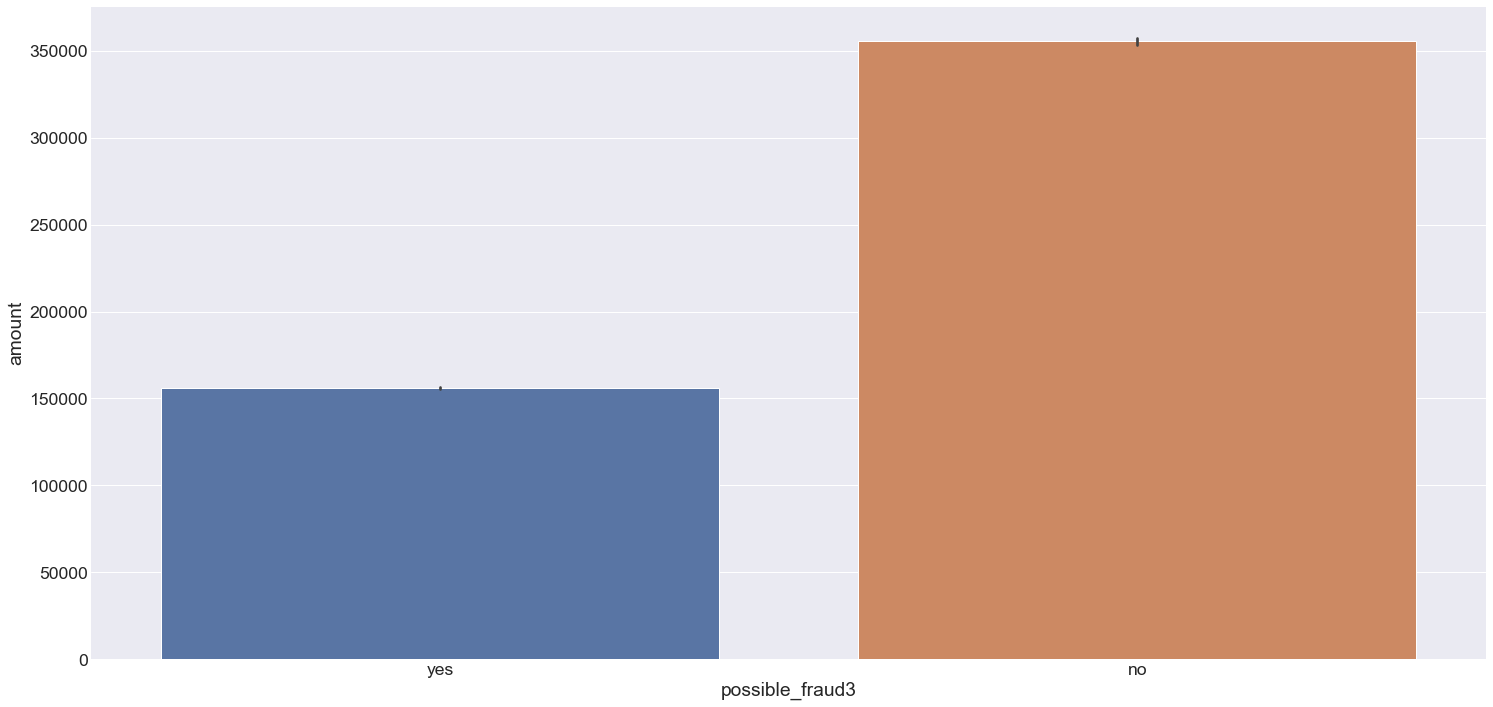

In [37]:
sns.barplot(y='amount', x='possible_fraud3', data=data);

###  60% of fraud transaction occours using cash-out-type method.

**FALSE:** The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

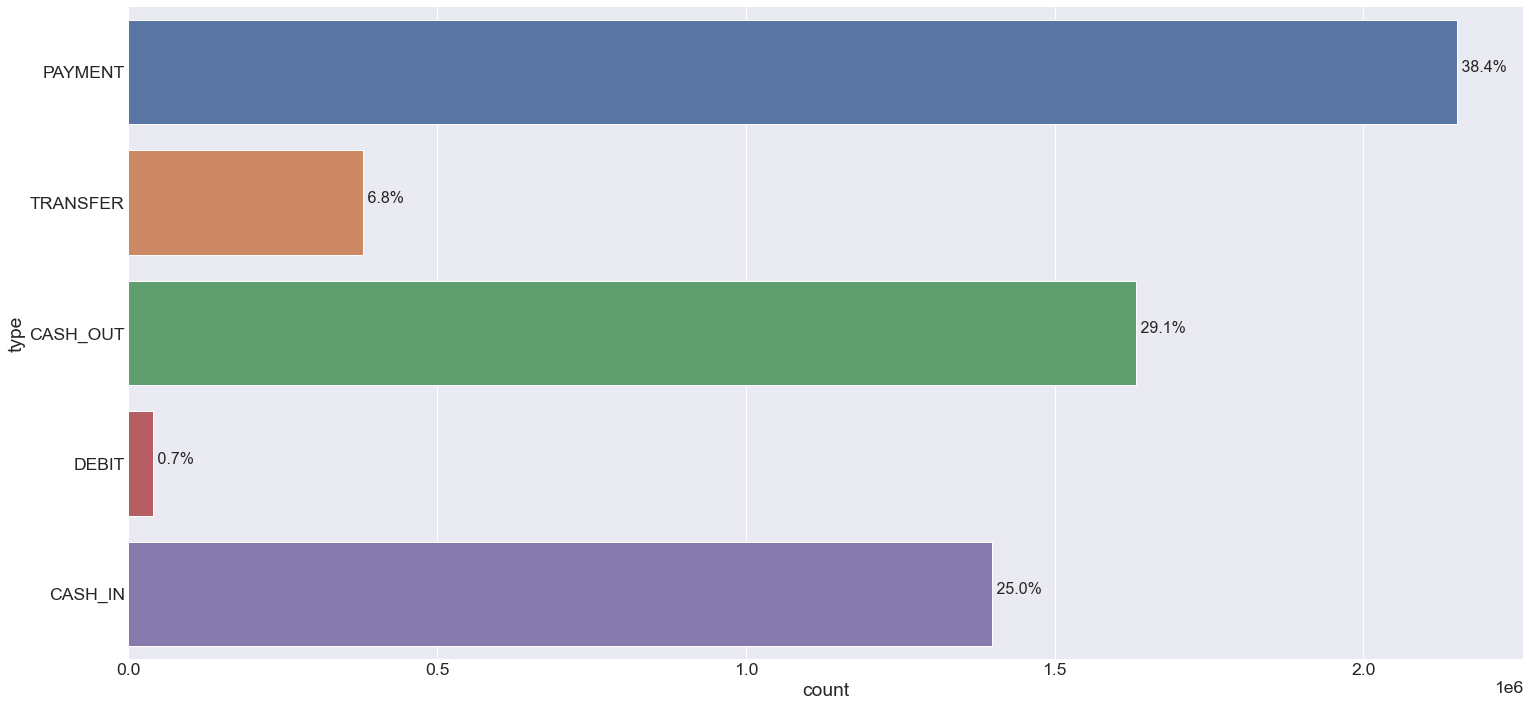

In [38]:
aux1 = data[data['possible_fraud3'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

To see the complete transiction-type and I'll plot them here.

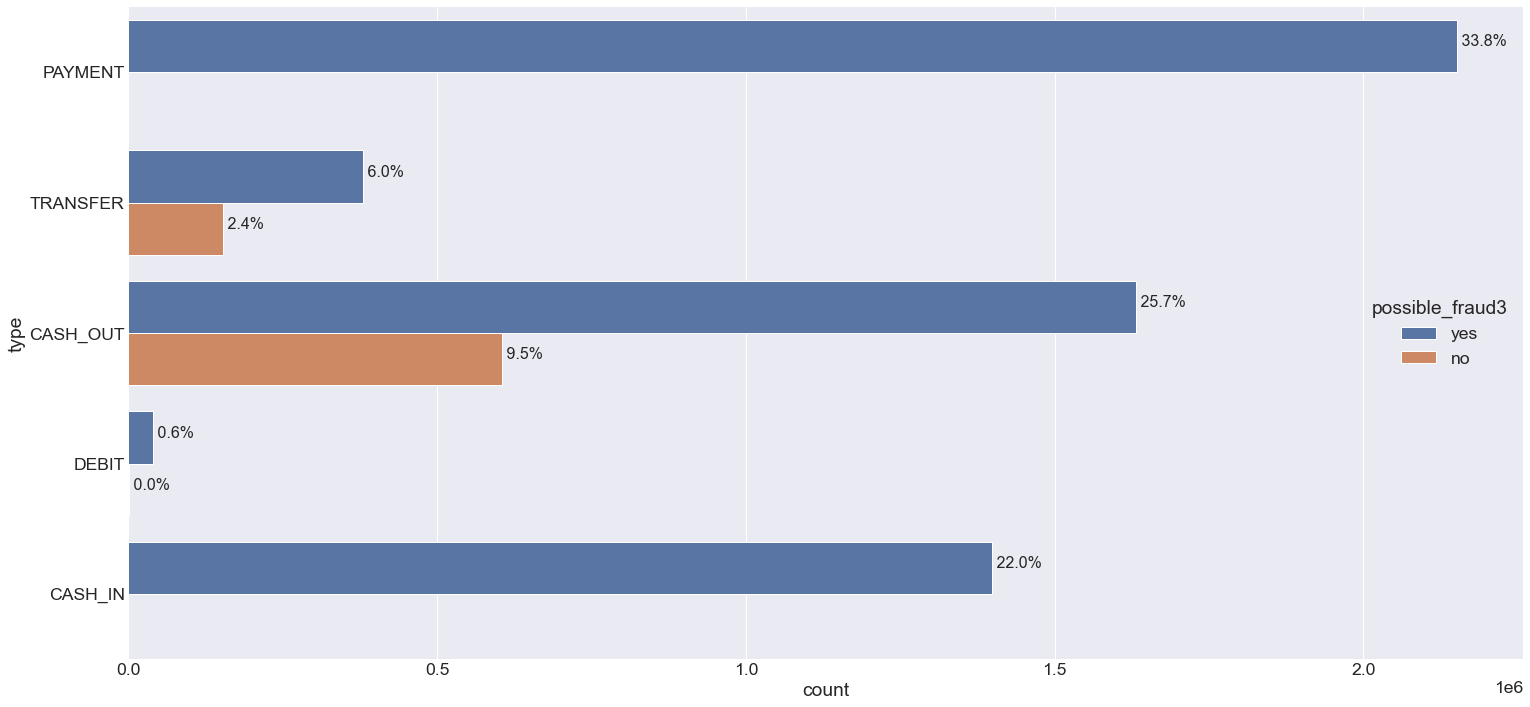

In [39]:
ax = sns.countplot(y='type', hue='possible_fraud3', data=data)

total = data['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H4 Values greater than 100.000 occours using transfers-type method.

**FALSE:** The majority transactions occours in trasnfer-type, however transactions greater than 100.000 occour in cash-out and cash-in too.

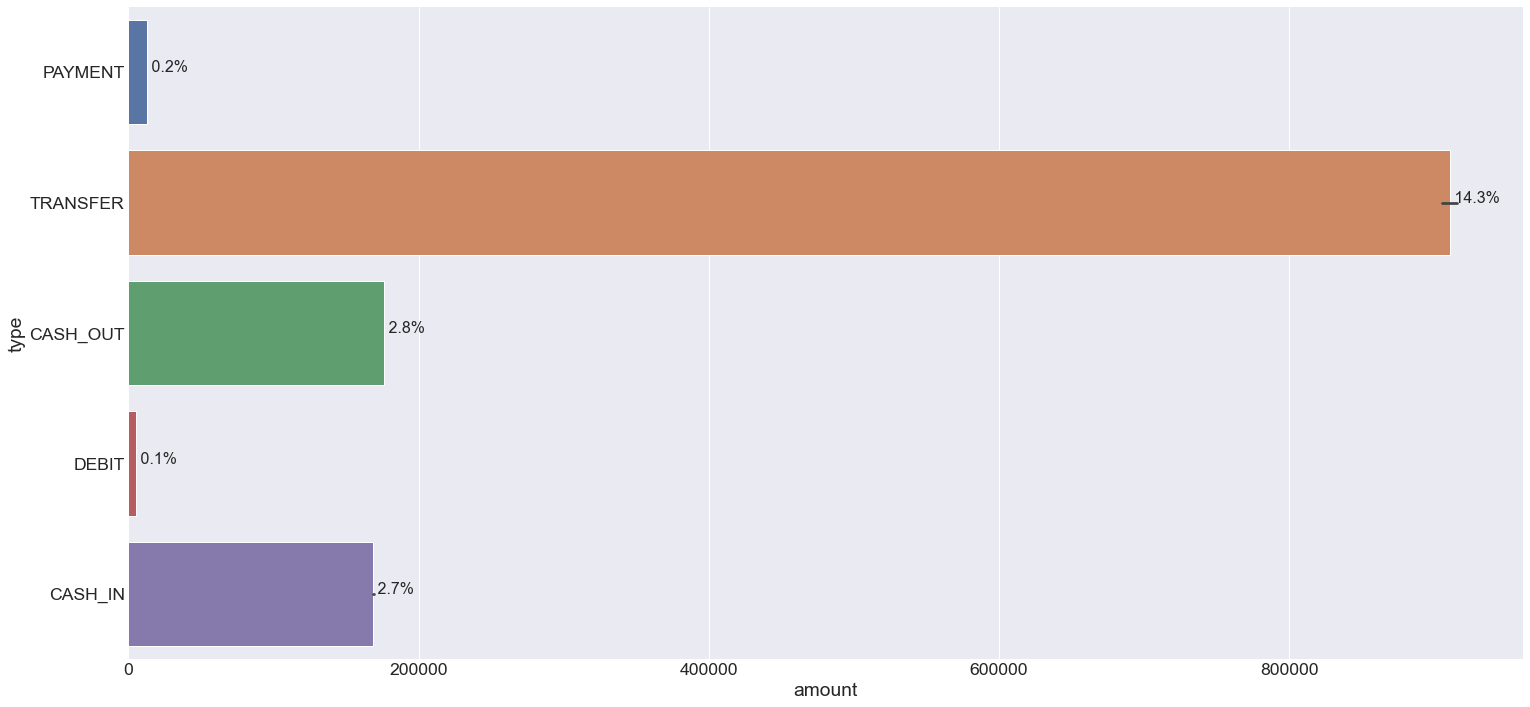

In [40]:
ax = sns.barplot(y='type', x='amount', data=data);

total = data['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

###  Fraud transactions occours at least in 3 days.

**TRUE:** The values for transactions and days in fraud aren't similar.

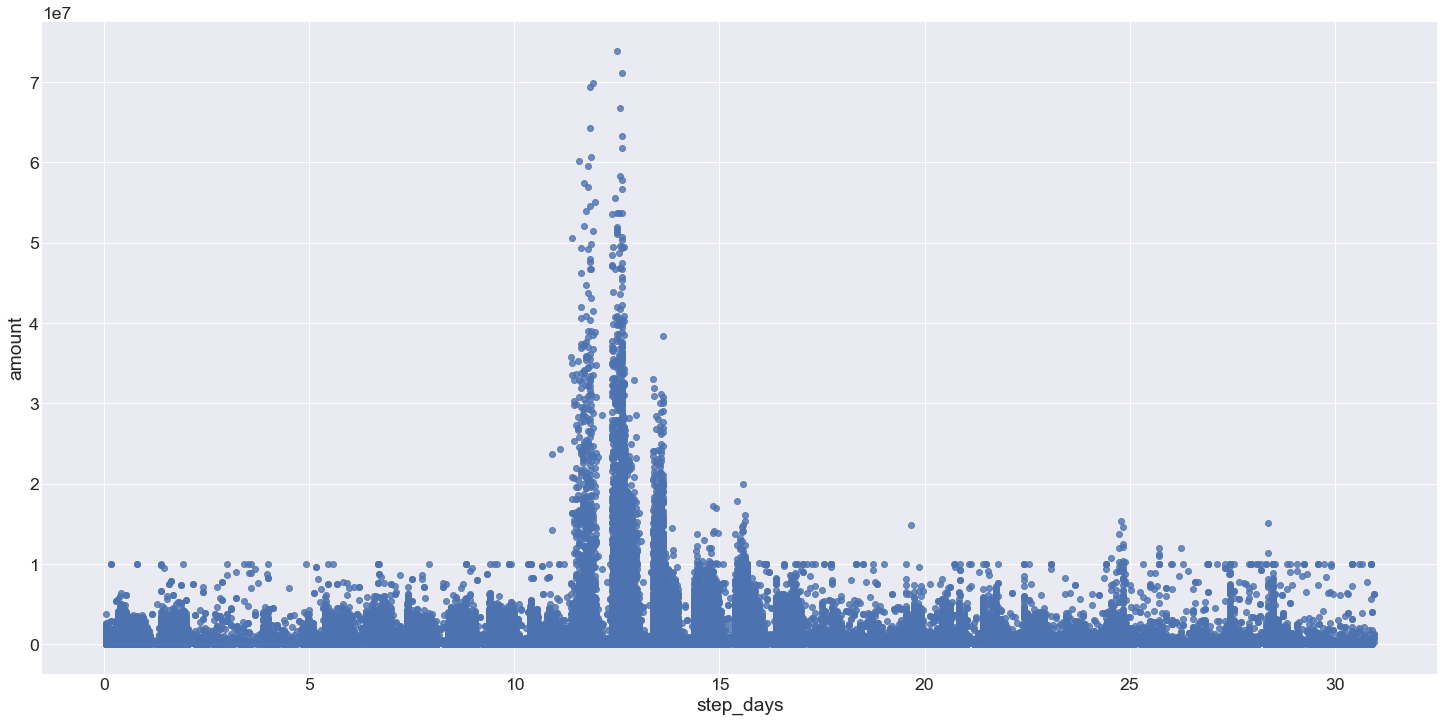

In [41]:
aux1 = data[data['possible_fraud3'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);  

## <font color = 'blue'> Multivariaty Analysis

###  Numerical Analysis

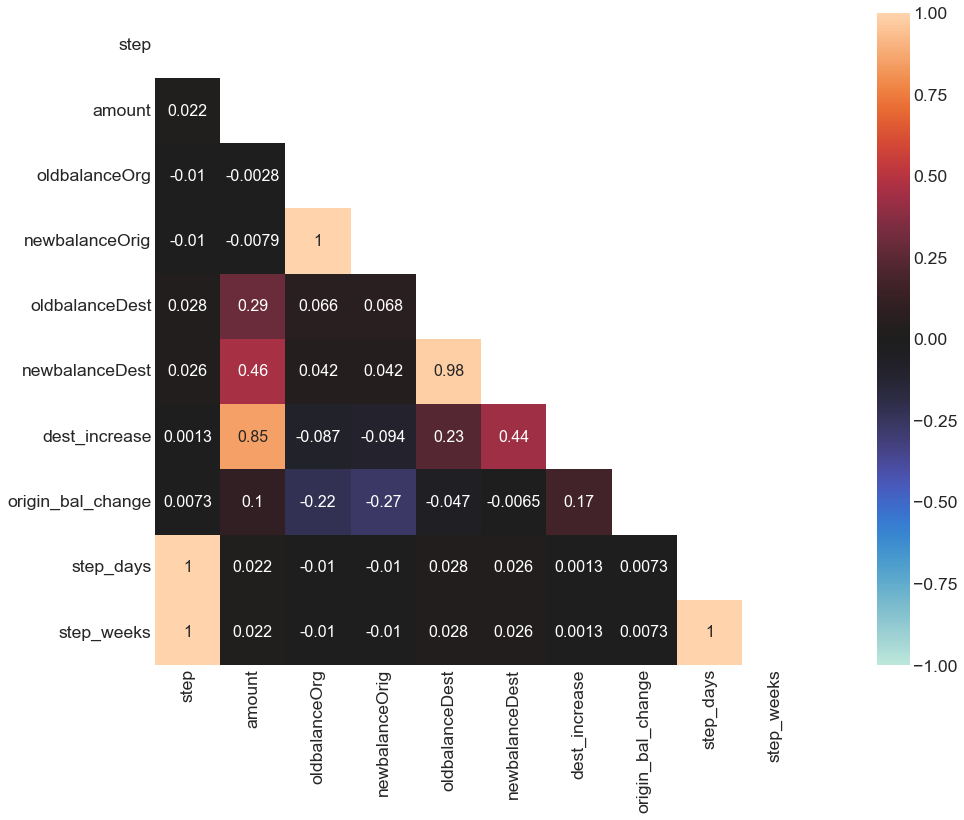

In [42]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

###  Categorical Variables

In [43]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}
    
    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])
        
corr = pd.DataFrame(dict_corr)

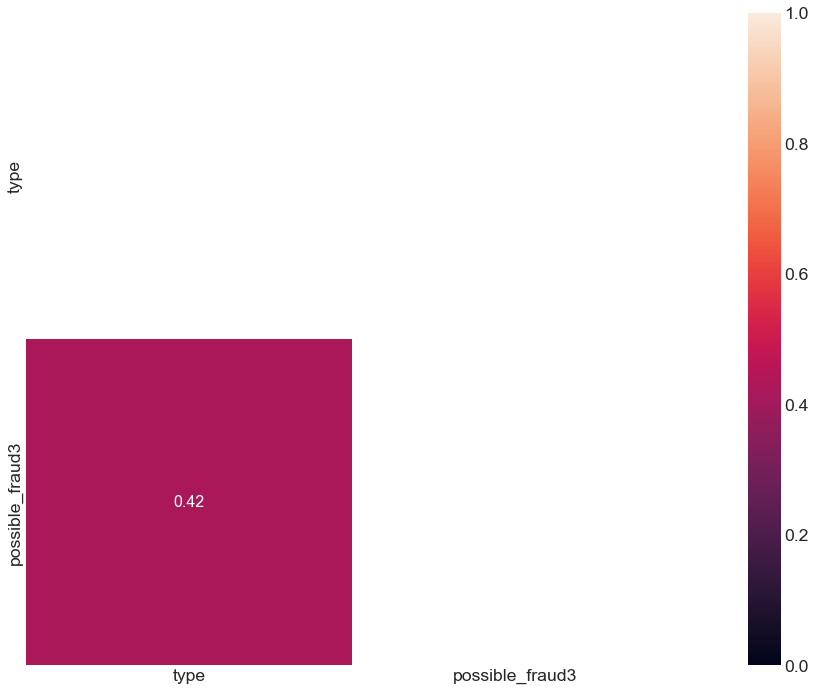

In [44]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

In [30]:
data['possible_fraud3'] = data['possible_fraud3'].map({'yes': 1, 'no': 0})

<AxesSubplot:>

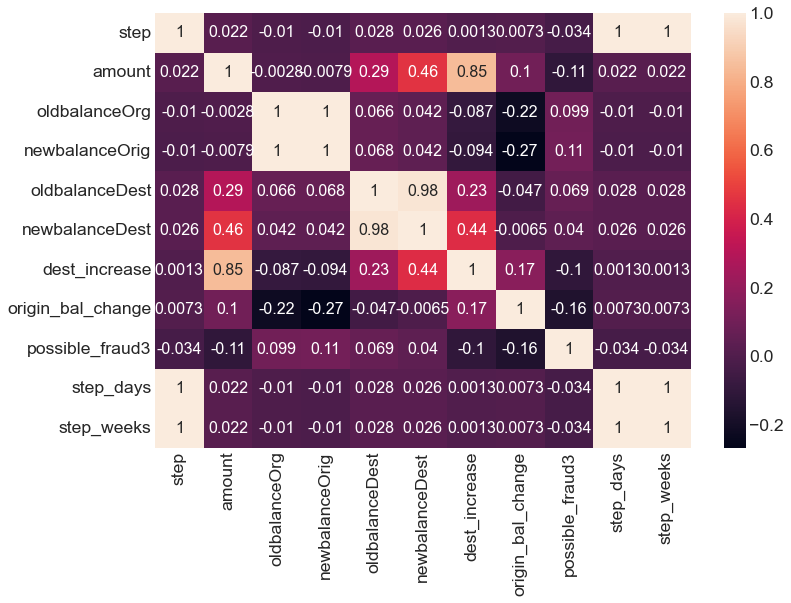

In [48]:
# checking the correlation between the variables with the target variable
data.corr()["possible_fraud3"].sort_values()

# heatmap of the correlation between the variables with the target variable
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True) 

# <font color = 'red'>Data Preparation

## <font color = 'blue'> Spliting into Train, Valid and Test

In [31]:
data1=data.copy()

In [32]:
data1.isna().mean()

step                 0.0
type                 0.0
amount               0.0
oldbalanceOrg        0.0
newbalanceOrig       0.0
oldbalanceDest       0.0
newbalanceDest       0.0
dest_increase        0.0
origin_bal_change    0.0
possible_fraud3      0.0
step_days            0.0
step_weeks           0.0
dtype: float64

In [33]:
data1=data1.drop(columns=["dest_increase","origin_bal_change","step_days","step_weeks"]
               ,axis=1)

In [34]:
data1.head()

step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0             0.0                1
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0             0.0                1
2     1  TRANSFER    181.00          181.0            0.00             0.0             0.0                1
3     1  CASH_OUT    181.00          181.0            0.00         21182.0             0.0                1
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0             0.0                1

In [35]:
from sklearn.preprocessing import LabelEncoder


In [36]:
le_encoder=LabelEncoder()


In [37]:
data1["Type"]=le_encoder.fit_transform( data1["type"])


In [38]:
data1.head()

step      type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type
0     1   PAYMENT   9839.64       170136.0       160296.36             0.0             0.0                1     3
1     1   PAYMENT   1864.28        21249.0        19384.72             0.0             0.0                1     3
2     1  TRANSFER    181.00          181.0            0.00             0.0             0.0                1     4
3     1  CASH_OUT    181.00          181.0            0.00         21182.0             0.0                1     1
4     1   PAYMENT  11668.14        41554.0        29885.86             0.0             0.0                1     3

In [39]:
le_encoder.inverse_transform(data1["Type"])

array(['PAYMENT', 'PAYMENT', 'TRANSFER', ..., 'CASH_OUT', 'TRANSFER',
       'CASH_OUT'], dtype=object)

In [40]:
data1[data1["type"]=="PAYMENT"].head(1)

step     type   amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type
0     1  PAYMENT  9839.64       170136.0       160296.36             0.0             0.0                1     3

In [41]:
data1[data1["type"]=="CASH_OUT"].head(1)

step      type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type
3     1  CASH_OUT   181.0          181.0             0.0         21182.0             0.0                1     1

In [42]:
data1[data1["type"]=="CASH_IN"].head(1)

step     type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type
389     1  CASH_IN  143236.26            0.0       143236.26       608932.17        97263.78                1     0

In [43]:
data1[data1["type"]=="TRANSFER"].head(1)

step      type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type
2     1  TRANSFER   181.0          181.0             0.0             0.0             0.0                1     4

In [44]:
data1[data1["type"]=="DEBIT"].head(1)

step   type   amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type
9     1  DEBIT  5337.77        41720.0        36382.23         41898.0        40348.79                1     2

In [45]:
data1.drop(['type'],axis=1,inplace = True)

In [46]:
X = data1.drop(columns=['possible_fraud3','step'], axis=1)
y = data1['possible_fraud3']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25, random_state = 0)

## <font color = 'blue'> One Hot Encoder   

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
#Standardizing the numerical columns
col_names=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] =features_test

##  <font color = 'blue'>Logistic Regression  Before Undersampling

In [49]:
print('Total no.of samples:Training and Testing dataset separately!')
print ('X_train:', np.shape(X_train))
print ('y_train:', np.shape(y_train))
print ('X_test:', np.shape(X_test))
print ('y_test:', np.shape(y_test))

Total no.of samples:Training and Testing dataset separately!
X_train: (4771965, 6)
y_train: (4771965,)
X_test: (1590655, 6)
y_test: (1590655,)


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [51]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression()

In [52]:
y_pred=classifier.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[  13439  176523]
 [  11011 1389682]]


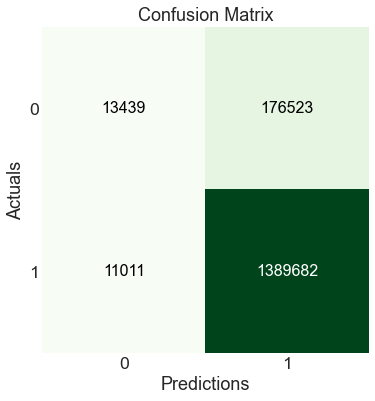

In [54]:
from mlxtend.plotting import plot_confusion_matrix
fig,ax=plot_confusion_matrix(conf_mat=cm,figsize=(6,6),cmap=plt.cm.Greens)
plt.xlabel('Predictions',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

In [55]:
logreg=accuracy_score(y_test,y_pred)
logreg

0.882102655824173

In [56]:
roc_auc_score(y_test,y_pred)

0.5314423096709094

In [57]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.07      0.13    189962
           1       0.89      0.99      0.94   1400693

    accuracy                           0.88   1590655
   macro avg       0.72      0.53      0.53   1590655
weighted avg       0.85      0.88      0.84   1590655



In [58]:
generate_model_report(y_test, y_pred)

Accuracy = 0.882102655824173
Precision = 0.8872925319482443
Recall =  0.9921388912488318
F1 Score = 0.9367912209991716


## <font color = 'blue'> XGBoost Before Undersampling


In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [60]:
data1['days'] = data1['step'].apply(lambda x : math.ceil(x/24))
data1.drop("step", axis=1, inplace=True)
data1.head()

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type  days
0   9839.64       170136.0       160296.36             0.0             0.0                1     3     1
1   1864.28        21249.0        19384.72             0.0             0.0                1     3     1
2    181.00          181.0            0.00             0.0             0.0                1     4     1
3    181.00          181.0            0.00         21182.0             0.0                1     1     1
4  11668.14        41554.0        29885.86             0.0             0.0                1     3     1

In [61]:
print ('X_train:', np.shape(X_train))
print ('y_train:', np.shape(y_train))
print ('X_test:', np.shape(X_test))
print ('y_test:', np.shape(y_test))

X_train: (4771965, 6)
y_train: (4771965,)
X_test: (1590655, 6)
y_test: (1590655,)


In [62]:
XGBclassifier = xgb.XGBClassifier()  
XGBclassifier.fit(X_train, y_train)
y_pred_xgb = XGBclassifier.predict(X_test) 

In [63]:
print(confusion_matrix(y_test, y_pred_xgb))

[[ 106873   83089]
 [  13972 1386721]]


In [64]:
xgb=accuracy_score(y_test,y_pred_xgb)
xgb

0.9389804828828375

In [65]:
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.88      0.56      0.69    189962
           1       0.94      0.99      0.97   1400693

    accuracy                           0.94   1590655
   macro avg       0.91      0.78      0.83   1590655
weighted avg       0.94      0.94      0.93   1590655



In [66]:
generate_model_report(y_test, y_pred_xgb)

Accuracy = 0.9389804828828375
Precision = 0.9434695640933182
Recall =  0.9900249376558603
F1 Score = 0.9661867623897274


In [67]:
print(roc_auc_score(y_test, XGBclassifier.predict_proba(X_test)[:, 1]))

0.960943697133749


## <font color = 'red'> Undersampling


In [69]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   amount           float64
 1   oldbalanceOrg    float64
 2   newbalanceOrig   float64
 3   oldbalanceDest   float64
 4   newbalanceDest   float64
 5   possible_fraud3  int64  
 6   Type             int32  
 7   days             int64  
dtypes: float64(5), int32(1), int64(2)
memory usage: 364.1 MB


In [70]:
data1.head(2)

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type  days
0  9839.64       170136.0       160296.36             0.0             0.0                1     3     1
1  1864.28        21249.0        19384.72             0.0             0.0                1     3     1

In [71]:
target = 'possible_fraud3'

In [72]:
X = data1.loc[:,data1.columns!=target]

In [73]:
Y = data1.loc[:,data1.columns==target]

In [74]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'type'.
data1['Type']= label_encoder.fit_transform(data1['Type'])

In [75]:
data1.head()

amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  possible_fraud3  Type  days
0   9839.64       170136.0       160296.36             0.0             0.0                1     3     1
1   1864.28        21249.0        19384.72             0.0             0.0                1     3     1
2    181.00          181.0            0.00             0.0             0.0                1     4     1
3    181.00          181.0            0.00         21182.0             0.0                1     1     1
4  11668.14        41554.0        29885.86             0.0             0.0                1     3     1

### <font color = 'blue'> Before Undersampling ratio of Fraud and Non Fraud cases

1    5602260
0     760360
Name: possible_fraud3, dtype: int64


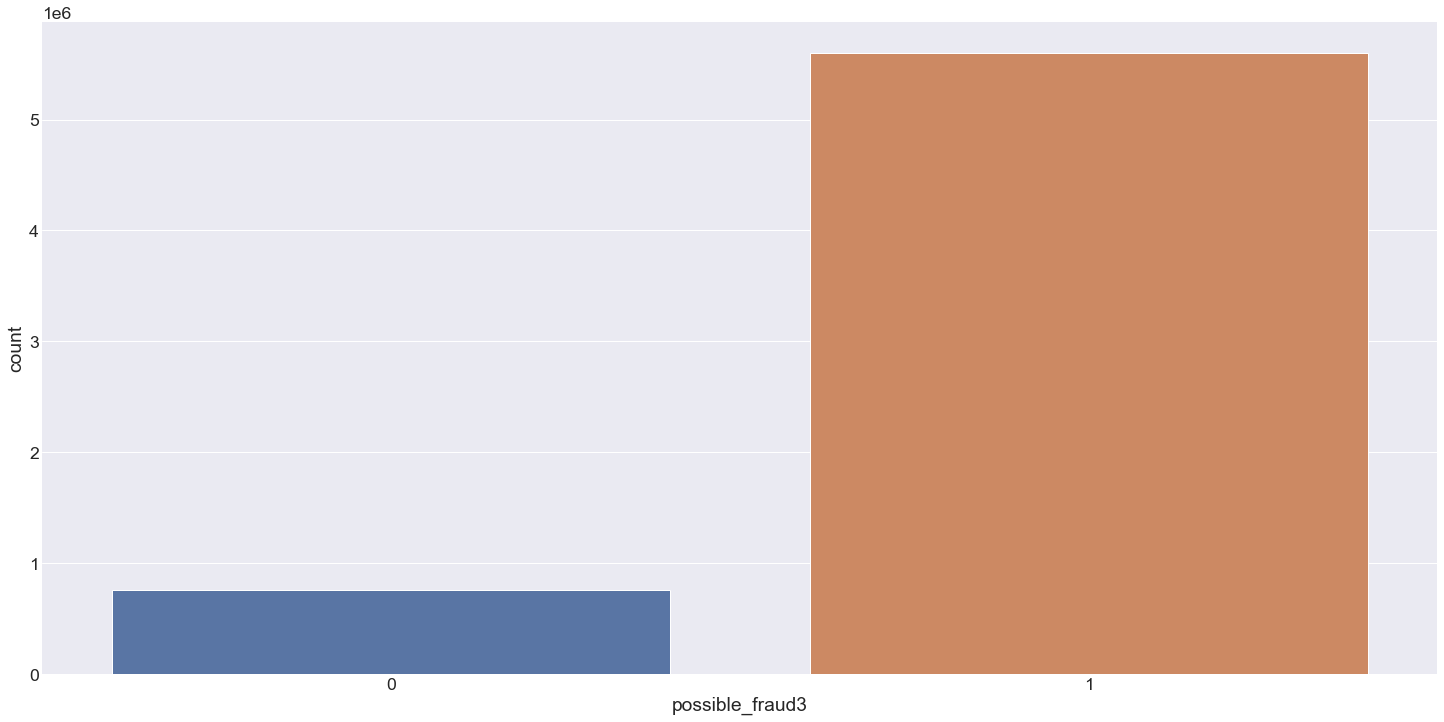

In [76]:
ax = sns.countplot(x=target, data=data1)
print(data1[target].value_counts())

In [77]:
100* (5602260/float(data1.shape[0]))

88.04957706102203

In [78]:
100* (760360/float(data1.shape[0]))

11.950422938977969

In [79]:
minority_class_len = len(data1[data1[target] == 0])
print(minority_class_len)

760360


In [80]:
majority_class_indices = data1[data1[target] == 1].index
print(majority_class_indices)

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            6362609, 6362610, 6362611, 6362612, 6362613, 6362614, 6362616,
            6362617, 6362618, 6362619],
           dtype='int64', length=5602260)


In [81]:
random_majority_indices = np.random.choice(majority_class_indices,
                                                minority_class_len,
                                                replace=False)
print(len(random_majority_indices))

760360


In [82]:
minority_class_indices = data1[data1[target] == 0].index
print(minority_class_indices)

Int64Index([    811,    1169,    1204,    1428,    1870,    1911,    1978,
               2110,    2125,    2220,
            ...
            6362583, 6362585, 6362589, 6362591, 6362595, 6362601, 6362603,
            6362605, 6362607, 6362615],
           dtype='int64', length=760360)


In [83]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [84]:
under_sample = data1.loc[under_sample_indices]

### <font color = 'blue'> After Undersampling ratio of Fraud and Non Fraud cases

1    5602260
0     760360
Name: possible_fraud3, dtype: int64


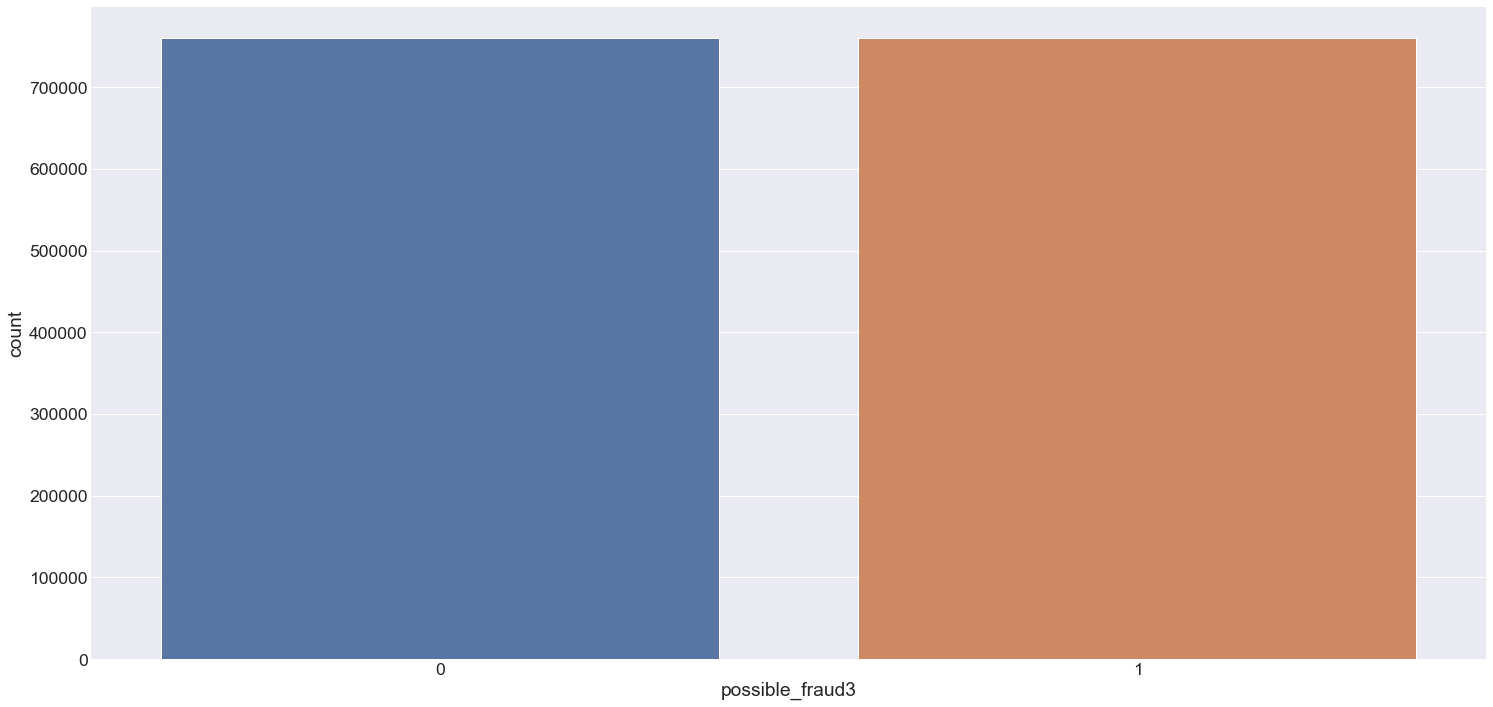

In [85]:
ax = sns.countplot(x=target, data=under_sample)
print(data1[target].value_counts())

##  <font color = 'blue'>Logistic Regression  AFter Undersampling

In [86]:
X = under_sample.drop(columns=['possible_fraud3'], axis=1)
y = under_sample['possible_fraud3']

In [87]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [88]:
print('Total no.of samples:Training and Testing dataset separately!')
print ('X_train:', np.shape(X_train))
print ('y_train:', np.shape(y_train))
print ('X_test:', np.shape(X_test))
print ('y_test:', np.shape(y_test))

Total no.of samples:Training and Testing dataset separately!
X_train: (1216576, 7)
y_train: (1216576,)
X_test: (304144, 7)
y_test: (304144,)


In [89]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [90]:
classifier=LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression()

In [91]:
y_pred=classifier.predict(X_test)

In [92]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[131961  20097]
 [ 34748 117338]]


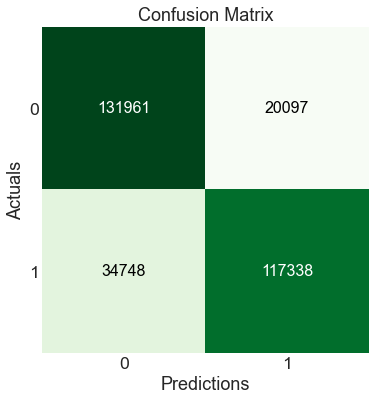

In [93]:
from mlxtend.plotting import plot_confusion_matrix
fig,ax=plot_confusion_matrix(conf_mat=cm,figsize=(6,6),cmap=plt.cm.Greens)
plt.xlabel('Predictions',fontsize=18)
plt.ylabel('Actuals',fontsize=18)
plt.title('Confusion Matrix',fontsize=18)
plt.show()

In [94]:
logreg=accuracy_score(y_test,y_pred)
logreg

0.8196742332579304

In [95]:
roc_auc_score(y_test,y_pred)

0.819678666455654

In [96]:
import sklearn.metrics as metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83    152058
           1       0.85      0.77      0.81    152086

    accuracy                           0.82    304144
   macro avg       0.82      0.82      0.82    304144
weighted avg       0.82      0.82      0.82    304144



In [97]:
generate_model_report(y_test, y_pred)

Accuracy = 0.8196742332579304
Precision = 0.8537708735038382
Recall =  0.7715240061544126
F1 Score = 0.810566418325441


## <font color = 'blue'> XG Boost after Undersampling

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [99]:
# Splitting the dataset into training and test set.  
from sklearn.model_selection import train_test_split  

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size= 0.20, random_state=42)

In [100]:
print ('x_train:', np.shape(X_train))
print ('y_train:', np.shape(y_train))
print ('x_test:', np.shape(X_test))
print ('y_test:', np.shape(y_test))

x_train: (1216576, 7)
y_train: (1216576,)
x_test: (304144, 7)
y_test: (304144,)


In [101]:
XGBclassifier = xgb.XGBClassifier()  
XGBclassifier.fit(x_train, y_train)
y_pred_xgb = XGBclassifier.predict(x_test) 

In [102]:
print(confusion_matrix(y_test, y_pred_xgb))

[[140056  11313]
 [ 22373 130402]]


In [103]:
xgb=accuracy_score(y_test,y_pred_xgb)
xgb

0.8892432531958546

In [104]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89    151369
           1       0.92      0.85      0.89    152775

    accuracy                           0.89    304144
   macro avg       0.89      0.89      0.89    304144
weighted avg       0.89      0.89      0.89    304144



In [105]:
generate_model_report(y_test, y_pred_xgb)

Accuracy = 0.8892432531958546
Precision = 0.9201707652683202
Recall =  0.8535558828342333
F1 Score = 0.8856124146830113


In [106]:
print(roc_auc_score(y_test, XGBclassifier.predict_proba(x_test)[:, 1]))

0.9611900098904131


## <font color = 'red'>Model deployment

In [120]:
import pickle


In [126]:
filename = 'trained_model.sav'
pickle.dump(XGBclassifier, open(filename, 'wb'))

In [127]:
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

In [128]:

input_data = (339682.13, 339682.13, 0.0, 0.00, 339682.13, 2, 1)
input_data1 = np.array(input_data, dtype=float)
input_data2 = [float(i) for i in input_data]
input_data_as_numpy_array = np.asarray(input_data2)


input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)
prediction = loaded_model.predict(input_data_reshaped)
print(prediction)
if (prediction[0] == 0):
    print('Not Fraud')
else:
    print('Fraud')

[0]
Not Fraud
